In [39]:
import os
import madmom
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from datasets import Dataset
from modules.energy_based import simple_energy_onsets
from modules.vis import onset_visualizer, passage_extractor, slur_visualizer
from modules.analysis_funcs import get_segmented_data, get_test_peaks, merging_module, slur_alignment

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:

ds0 = Dataset("initslurtest")
ds1 = Dataset("slurtest_add_1")
ds_test = Dataset("slurtest_test")

audio_fnames = ds_test.get_audio_paths()
label_fnames = ds_test.get_annotation_paths()
audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [np.loadtxt(label_fname, usecols=0) for label_fname in label_fnames]
audio_lengths = [len(audio)/sr for audio, sr in zip(audios, sample_rates)]

/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [41]:
# CNN method
base_path = "results/cnn-training-220426/"
model_name = "ab-seq-90eps-nostandard-trainable-noextend-dropout0.3"
model = tf.keras.models.load_model(base_path + 'fold_{}_{}_model'.format(0, model_name))

In [86]:
R = 2

cnn_input = get_segmented_data(audio_fnames[R])
cnn_output = model.predict(cnn_input)
cnn_onsets = get_test_peaks(cnn_output, 1./100)

bock = madmom.features.onsets.CNNOnsetProcessor()
pp = madmom.features.onsets.OnsetPeakPickingProcessor(threshold=0.7, combine=0.1)
bock_onsets = pp(bock(audios[R]))
hard_idx, soft_idx = merging_module(bock_onsets, cnn_onsets, tol_sec=0.05)

slur_onehot = slur_alignment(hard_idx, soft_idx)

hard_gt, soft_gt = merging_module(
    bock_onsets, # Böck NOD
    onset_schedules[R], # HOD annotations
    tol_sec=0.05
)
slur_true = slur_alignment(hard_idx, soft_idx)


In [88]:
cnn_onsets[:10]

array([0.04, 2.24, 2.51, 3.01, 3.5 , 4.  , 4.5 , 5.  , 5.23, 5.48],
      dtype=float32)

Audio length:  52.43732426303855  s
Segments: [0.0, 8.0, 16.0, 24.0, 32.0, 40.0, 48.0, 56.0]
Note onset: 1.9
Matches:  [1 0 0 0 0 0 0 0 0 0 0 0 0]
Match!
Note onset: 2.26
Matches:  [0 0 0 0 0 0 0 0 0 0 0 0 0]
No match!
Note onset: 2.52
Matches:  [0 1 0 0 0 0 0 0 0 0 0 0 0]
Match!
Note onset: 3.01
Matches:  [0 0 1 0 0 0 0 0 0 0 0 0 0]
Match!
Note onset: 3.5
Matches:  [0 0 0 1 0 0 0 0 0 0 0 0 0]
Match!
Note onset: 3.75
Matches:  [0 0 0 0 0 0 0 0 0 0 0 0 0]
No match!
Note onset: 3.95
Matches:  [0 0 0 0 0 0 0 0 0 0 0 0 0]
No match!
Note onset: 4.25
Matches:  [0 0 0 0 0 0 0 0 0 0 0 0 0]
No match!
Note onset: 4.5
Matches:  [0 0 0 0 0 1 0 0 0 0 0 0 0]
Match!
Note onset: 4.71
Matches:  [0 0 0 0 0 0 0 0 0 0 0 0 0]
No match!
Note onset: 4.99
Matches:  [0 0 0 0 0 0 1 0 0 0 0 0 0]
Match!
Note onset: 5.2
Matches:  [0 0 0 0 0 0 0 0 0 0 0 0 0]
No match!
Note onset: 5.48
Matches:  [0 0 0 0 0 0 0 1 0 0 0 0 0]
Match!
Note onset: 5.7
Matches:  [0 0 0 0 0 0 0 0 0 0 0 0 0]
No match!
Note onset: 5.98
Matche

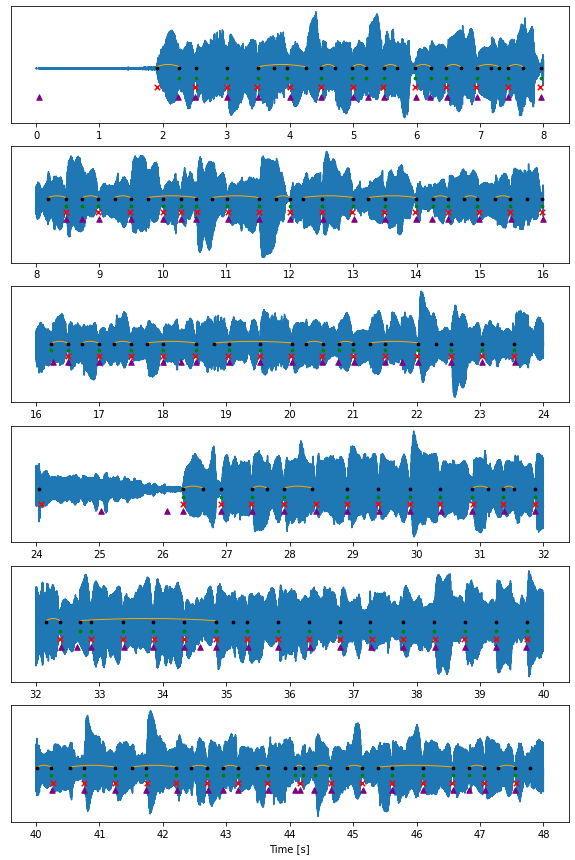

In [83]:

SPP = 8.0 # seconds per plot
print("Audio length: ", audio_lengths[R], " s")
print("Segments:", list(np.arange(0, audio_lengths[R]+SPP, SPP)))
N_PLOTS = int(audio_lengths[R]/SPP)+1
plot_slurs = True

passages = passage_extractor(
    audios[R], 
    [
        bock_onsets,
        bock_onsets[hard_idx],
        onset_schedules[R],
        cnn_onsets,
        
    ],
    np.arange(0, audio_lengths[R], SPP), 
    sr=sample_rates[R]
)

fig,axs = plt.subplots(len(passages),1, figsize=(10,2.5*len(passages)))
onset_styles = {"m":[".",".","x", "^"], "c":["k","green", "r", "purple"]}
axs[-1].set_xlabel("Time [s]")

for plot_i, (passage, ax) in enumerate(zip(passages, axs)):
    ax.set_yticks([])
    onset_visualizer(
        passage["audio"], 
        passage["onsets"], 
        (passage["abs_start"], passage["abs_end"]),
        onset_styles=onset_styles,
        ax=ax
        )
    if plot_slurs:
        hard, soft = merging_module(
            passage["onsets"][0], # Böck NOD
            passage["onsets"][2], # CNN HOD
            tol_sec=0.05
        )
        slur_visualizer(
            passage["onsets"][0],
            slur_alignment(hard, soft),
            ax=ax,
            edgecolor="orange",
            sign=0.2
        )

In [73]:
len(passages)

6

In [55]:
passages = [passage_extractor(
    audios[R], 
    onset_set,
    [0,10.2], 
    sr=sample_rates[R]
)[0] for onset_set in [
    [
        onset_schedules[R],
        cnn_onsets
    ],
    [
        bock_onsets,
    ],
]
]

fig,axs = plt.subplots(len(passages),1, figsize=(10,2.5*len(passages)), sharex=True)
onset_styles = [
    {"m":["x", "^"], "c":["r", "purple"]},
    {"m":["."], "c":["k"]}
]

hard_idx, soft_idx = merging_module(
    passages[1]["onsets"][0], # Böck NOD
    passages[0]["onsets"][1], # CNN HOD
    tol_sec=0.05
)

hard_gt, soft_gt = merging_module(
    passages[1]["onsets"][0], # Böck NOD
    passages[0]["onsets"][0], # HOD annotations
    tol_sec=0.05
)

for plot_i, (passage, ax, onset_style) in enumerate(zip(passages, axs, onset_styles)):
    ax.set_yticks([])
    onset_visualizer(
        passage["audio"], 
        passage["onsets"], 
        (passage["abs_start"], passage["abs_end"]),
        onset_styles=onset_style,
        ax=ax
        )

    if plot_i==1:
        ax.set_xlabel("Time [s]")
        for hard, soft, sign, color in zip(
            [hard_idx, hard_gt],
            [soft_idx, soft_gt],
            [-1,1],
            ["purple", "red"]
        ):
            slur_visualizer(
                passages[1]["onsets"][0],
                slur_alignment(hard, soft),
                ax=ax,
                edgecolor=color,
                sign=sign
            )

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
